# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [17]:
import pickle

# Load pickled data
# TODO: fill this in based on where you saved the training and testing data
training_file = "/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/traffic-signs-data/train.p"
testing_file = "/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [18]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Image data: ", X_train.shape)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image data:  (39209, 32, 32, 3)


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
print(X_train[0].shape)

#Preprocessing -- Transformation & grayscale
train_gray = np.zeros((n_train,1024))
for i in range(n_train):
    #the cv2,cvtColor(image, cv2.RGB2GRAY) function converts a 3 channel image to a single channel image
    train_gray[i] = cv2.cvtColor( X_train[i], cv2.COLOR_BGR2GRAY ).flatten()

test_gray = np.zeros((n_test,1024))
for i in range(n_test):
    #the cv2,cvtColor(image, cv2.RGB2GRAY) function converts a 3 channel image to a single channel image
    test_gray[i] = cv2.cvtColor( X_test[i], cv2.COLOR_BGR2GRAY ).flatten()
    

#plt.imshow(gray)
print(train_gray.shape)
print(test_gray.shape)

(32, 32, 3)
(39209, 1024)
(12630, 1024)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [20]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#Preprocessing -- Normalization for zero mean and equal variance
#Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

train_gray = normalize_greyscale(train_gray)
print(train_gray.shape)

test_gray = normalize_greyscale(test_gray)
print(test_gray.shape)

(39209, 1024)
(12630, 1024)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
To preprocess the data, these are the steps I implemented: 
1) Convert the images from BGR to grayscale. Converting images to gray scale reduces the total size of the dataset by by going from 3 color channels to 1. Helps improve the speed of the algorithm without sacrificing much information. The main features of a traffic sign are present in the shapes of the signs. Leveraged OpenCV functions to make the transformations. 
2) Flattened the images from 32x32 to 1024 
3) Normalized the feature data using min/max scale. Normalization helps to standardize the inputs to make training faster and avoid getting stuck in local optima. Reference: http://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network 
4) Performed one-hot label encoding of train and test data. This encoding is needed for feeding categorical data to the linear model. Reference: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [21]:
is_labels_encod = False
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    is_labels_encod = True

print("Train labels: ", y_train.shape)
print('Labels One-Hot Encoded')

Train labels:  (39209, 43)
Labels One-Hot Encoded


In [22]:
#Randmoized datasets for training and validation
train_features,valid_features, train_labels, valid_labels = train_test_split(train_gray,
                                                                             y_train,
                                                                             test_size=0.05,
                                                                             random_state=832289)
print ("Training set: ",len(train_labels))
print ("Validation set: ",len(valid_labels))
print(train_features.shape)
print(train_labels.shape)
print(valid_features.shape)
print(valid_labels.shape)
print(test_gray.shape)

Training set:  37248
Validation set:  1961
(37248, 1024)
(37248, 43)
(1961, 1024)
(1961, 43)
(12630, 1024)


In [23]:
import tensorflow as tf
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#The weights must be the dimensions of features by labels. The number of features is the size of the image, 32x32=1024. 
features_count = 1024
#The biases must be the dimensions of the labels, which is 10.
labels_count = 43

#Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

#Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
Performed One hot encoding of the labels.
Split the training set into 2 datasets, training and valdiation sets using: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split. Test data set is not split.Weights and biases initialized based on the feature and label counts



In [24]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 1024]), 'The shape of features is incorrect'
assert labels._shape in [None, 10], 'The shape of labels is incorrect'
assert weights._variable._shape == (1024, 43), 'The shape of weights is incorrect'
assert biases._variable._shape == (43), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_gray, labels: y_test}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    a = session.run(features, feed_dict=train_feed_dict)
    b = session.run(weights)
    c = session.run(biases)
    print("features = ",a.shape)
    print("weights = ",b.shape)
    print("biases = ",c.shape)
    session.run(logits, feed_dict=train_feed_dict)

print(logits)    

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), 
                                             reduction_indices=[1]))

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Test Cases
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    #pred = session.run(prediction,feed_dict=test_feed_dict)
    session.run(loss, feed_dict=train_feed_dict)
    #session.run(loss, feed_dict=valid_feed_dict)
    #session.run(loss, feed_dict=test_feed_dict)
    #print(pred)
    #print("train_loss = ",train_loss)
    #print("valid_loss = ",valid_loss)
    #print("test_loss = ",test_loss)
    biases_data = session.run(biases)
    
assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
features =  (37248, 1024)
weights =  (1024, 43)
biases =  (43,)
Tensor("add_1:0", shape=(?, 43), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Tests Passed!


In [25]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The architecture leverages Linear model application on inputs, weights and bias 
Calculate the softmax, cross_entropy, loss and accuracy of the prediction
CNN is not leveraged here



Epoch  1/500:   8%|▊         | 149/1863 [00:00<06:54,  4.13batches/s]

Validation accuracy:  0.0127486
Training accuracy:  0.0106851
Test accuracy:  0.0114806



Epoch  2/500:   4%|▍         | 79/1863 [00:00<08:28,  3.51batches/s]

Validation accuracy:  0.511984
Training accuracy:  0.505799
Test accuracy:  0.46635



Epoch  3/500:   4%|▍         | 82/1863 [00:00<09:04,  3.27batches/s]

Validation accuracy:  0.614992
Training accuracy:  0.622423
Test accuracy:  0.562312



Epoch 15/25:  21%|██▏       | 396/1863 [00:20<01:14, 19.79batches/s]
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/Users/sharanya.doddapaneni/anaconda/envs/nano/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/sharanya.doddapaneni/anaconda/envs/nano/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sharanya.doddapaneni/anaconda/envs/nano/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Epoch  4/500:   7%|▋         | 129/1863 [00:00<06:06,  4.73batches/s]

Validation accuracy:  0.681285
Training accuracy:  0.690749
Test accuracy:  0.619398


Epoch  5/500:   9%|▉         | 168/1863 [00:00<06:03,  4.66batches/s]

Validation accuracy:  0.713921
Training accuracy:  0.728388
Test accuracy:  0.652969


Epoch  6/500:   4%|▍         | 79/1863 [00:00<08:55,  3.33batches/s]

Validation accuracy:  0.739929
Training accuracy:  0.752389
Test accuracy:  0.677831


Epoch  7/500:   7%|▋         | 137/1863 [00:00<06:24,  4.49batches/s]

Validation accuracy:  0.750127
Training accuracy:  0.767639
Test accuracy:  0.693032


Epoch  8/500:   4%|▍         | 71/1863 [00:00<09:25,  3.17batches/s]

Validation accuracy:  0.762876
Training accuracy:  0.781008
Test accuracy:  0.704196


Epoch  9/500:   8%|▊         | 148/1863 [00:00<06:17,  4.55batches/s]

Validation accuracy:  0.775115
Training accuracy:  0.793412
Test accuracy:  0.714648


Epoch 10/500:   5%|▍         | 92/1863 [00:00<08:27,  3.49batches/s]

Validation accuracy:  0.787353
Training accuracy:  0.805493
Test accuracy:  0.723832


Epoch 11/500:   9%|▉         | 165/1863 [00:00<05:50,  4.84batches/s]

Validation accuracy:  0.797552
Training accuracy:  0.815131
Test accuracy:  0.730879


Epoch 12/500:   9%|▊         | 159/1863 [00:00<06:02,  4.70batches/s]

Validation accuracy:  0.802142
Training accuracy:  0.822487
Test accuracy:  0.737926


Epoch 13/500:   8%|▊         | 155/1863 [00:00<06:17,  4.53batches/s]

Validation accuracy:  0.809791
Training accuracy:  0.829951
Test accuracy:  0.742835


Epoch 14/500:   9%|▊         | 160/1863 [00:00<05:57,  4.76batches/s]

Validation accuracy:  0.811321
Training accuracy:  0.835857
Test accuracy:  0.74711


Epoch 15/500:  10%|▉         | 184/1863 [00:00<05:39,  4.94batches/s]

Validation accuracy:  0.8154
Training accuracy:  0.841334
Test accuracy:  0.750435


Epoch 16/500:   9%|▉         | 167/1863 [00:00<05:45,  4.91batches/s]

Validation accuracy:  0.81999
Training accuracy:  0.846193
Test accuracy:  0.752573


Epoch 17/500:  10%|▉         | 183/1863 [00:00<05:53,  4.75batches/s]

Validation accuracy:  0.824579
Training accuracy:  0.850757
Test accuracy:  0.755819


Epoch 18/500:   9%|▊         | 163/1863 [00:00<05:52,  4.82batches/s]

Validation accuracy:  0.828659
Training accuracy:  0.855428
Test accuracy:  0.760728


Epoch 19/500:   5%|▌         | 94/1863 [00:00<08:17,  3.56batches/s]

Validation accuracy:  0.833758
Training accuracy:  0.85908
Test accuracy:  0.76342


Epoch 20/500:   9%|▉         | 167/1863 [00:00<05:47,  4.88batches/s]

Validation accuracy:  0.837328
Training accuracy:  0.862355
Test accuracy:  0.766271


Epoch 21/500:  10%|█         | 189/1863 [00:00<05:25,  5.15batches/s]

Validation accuracy:  0.841407
Training accuracy:  0.865389
Test accuracy:  0.76825


Epoch 22/500:   4%|▍         | 82/1863 [00:00<08:46,  3.38batches/s]

Validation accuracy:  0.845997
Training accuracy:  0.868073
Test accuracy:  0.770309


Epoch 23/500:   4%|▍         | 77/1863 [00:00<08:41,  3.43batches/s]

Validation accuracy:  0.848547
Training accuracy:  0.871134
Test accuracy:  0.77213


Epoch 24/500:   4%|▍         | 75/1863 [00:00<09:02,  3.30batches/s]

Validation accuracy:  0.852116
Training accuracy:  0.874195
Test accuracy:  0.773872


Epoch 25/500:   9%|▉         | 166/1863 [00:00<06:00,  4.70batches/s]

Validation accuracy:  0.852116
Training accuracy:  0.877067
Test accuracy:  0.775376


Epoch 26/500:   5%|▍         | 89/1863 [00:00<08:36,  3.43batches/s]

Validation accuracy:  0.854156
Training accuracy:  0.879725
Test accuracy:  0.776801


Epoch 27/500:   4%|▍         | 82/1863 [00:00<09:06,  3.26batches/s]

Validation accuracy:  0.855686
Training accuracy:  0.882302
Test accuracy:  0.77791


Epoch 28/500:   3%|▎         | 63/1863 [00:00<10:33,  2.84batches/s]

Validation accuracy:  0.857216
Training accuracy:  0.884343
Test accuracy:  0.778701


Epoch 29/500:   4%|▎         | 67/1863 [00:00<10:01,  2.99batches/s]

Validation accuracy:  0.858236
Training accuracy:  0.886115
Test accuracy:  0.780602


Epoch 30/500:   6%|▌         | 113/1863 [00:00<08:30,  3.43batches/s]

Validation accuracy:  0.859765
Training accuracy:  0.887645
Test accuracy:  0.781235


Epoch 31/500:   5%|▌         | 100/1863 [00:00<08:59,  3.27batches/s]

Validation accuracy:  0.859765
Training accuracy:  0.889229
Test accuracy:  0.782502


Epoch 32/500:   7%|▋         | 122/1863 [00:00<06:41,  4.34batches/s]

Validation accuracy:  0.862825
Training accuracy:  0.890544
Test accuracy:  0.783531


Epoch 33/500:   4%|▍         | 80/1863 [00:00<09:34,  3.10batches/s]

Validation accuracy:  0.863335
Training accuracy:  0.891645
Test accuracy:  0.784323


Epoch 34/500:   7%|▋         | 134/1863 [00:00<06:56,  4.15batches/s]

Validation accuracy:  0.862825
Training accuracy:  0.893363
Test accuracy:  0.785115


Epoch 35/500:   6%|▌         | 115/1863 [00:00<08:08,  3.58batches/s]

Validation accuracy:  0.863335
Training accuracy:  0.894652
Test accuracy:  0.785748


Epoch 36/500:   3%|▎         | 61/1863 [00:00<11:31,  2.61batches/s]

Validation accuracy:  0.863845
Training accuracy:  0.89586
Test accuracy:  0.785907


Epoch 37/500:   8%|▊         | 146/1863 [00:00<06:36,  4.33batches/s]

Validation accuracy:  0.863335
Training accuracy:  0.897283
Test accuracy:  0.786698


Epoch 38/500:   5%|▌         | 102/1863 [00:00<08:23,  3.50batches/s]

Validation accuracy:  0.865375
Training accuracy:  0.898357
Test accuracy:  0.787648


Epoch 39/500:   5%|▍         | 92/1863 [00:00<08:51,  3.33batches/s]

Validation accuracy:  0.867415
Training accuracy:  0.899404
Test accuracy:  0.787965


Epoch 40/500:   7%|▋         | 137/1863 [00:00<06:59,  4.12batches/s]

Validation accuracy:  0.868944
Training accuracy:  0.900612
Test accuracy:  0.788836


Epoch 41/500:   3%|▎         | 63/1863 [00:00<11:39,  2.57batches/s]

Validation accuracy:  0.869964
Training accuracy:  0.901525
Test accuracy:  0.789549


Epoch 42/500:   6%|▋         | 119/1863 [00:00<07:40,  3.79batches/s]

Validation accuracy:  0.870984
Training accuracy:  0.902948
Test accuracy:  0.790261


Epoch 43/500:   7%|▋         | 138/1863 [00:00<06:29,  4.43batches/s]

Validation accuracy:  0.870984
Training accuracy:  0.904183
Test accuracy:  0.790816


Epoch 44/500:   3%|▎         | 53/1863 [00:00<11:28,  2.63batches/s]

Validation accuracy:  0.869964
Training accuracy:  0.905257
Test accuracy:  0.791686


Epoch 45/500:   5%|▌         | 101/1863 [00:00<07:54,  3.71batches/s]

Validation accuracy:  0.870984
Training accuracy:  0.906411
Test accuracy:  0.791924


Epoch 46/500:   4%|▎         | 67/1863 [00:00<10:41,  2.80batches/s]

Validation accuracy:  0.871494
Training accuracy:  0.907539
Test accuracy:  0.792478


Epoch 47/500:   4%|▎         | 68/1863 [00:00<09:37,  3.11batches/s]

Validation accuracy:  0.870474
Training accuracy:  0.908264
Test accuracy:  0.79327


Epoch 48/500:   8%|▊         | 158/1863 [00:00<06:22,  4.46batches/s]

Validation accuracy:  0.872004
Training accuracy:  0.908747
Test accuracy:  0.793191


Epoch 49/500:   4%|▎         | 69/1863 [00:00<09:29,  3.15batches/s]

Validation accuracy:  0.874044
Training accuracy:  0.909552
Test accuracy:  0.793824


Epoch 50/500:   7%|▋         | 132/1863 [00:00<06:07,  4.71batches/s]

Validation accuracy:  0.875574
Training accuracy:  0.910384
Test accuracy:  0.793983


Epoch 51/500:   4%|▍         | 72/1863 [00:00<09:58,  2.99batches/s]

Validation accuracy:  0.875574
Training accuracy:  0.911297
Test accuracy:  0.794616


Epoch 52/500:   6%|▌         | 109/1863 [00:00<08:05,  3.62batches/s]

Validation accuracy:  0.876594
Training accuracy:  0.912398
Test accuracy:  0.794616


Epoch 53/500:   6%|▋         | 119/1863 [00:00<07:52,  3.69batches/s]

Validation accuracy:  0.878123
Training accuracy:  0.912935
Test accuracy:  0.795091


Epoch 54/500:   6%|▋         | 118/1863 [00:00<08:13,  3.54batches/s]

Validation accuracy:  0.878123
Training accuracy:  0.913821
Test accuracy:  0.795329


Epoch 55/500:   5%|▍         | 88/1863 [00:00<08:53,  3.33batches/s]

Validation accuracy:  0.879143
Training accuracy:  0.914358
Test accuracy:  0.795645


Epoch 56/500:   6%|▌         | 111/1863 [00:00<08:38,  3.38batches/s]

Validation accuracy:  0.880163
Training accuracy:  0.915083
Test accuracy:  0.795962


Epoch 57/500:   3%|▎         | 63/1863 [00:00<11:02,  2.72batches/s]

Validation accuracy:  0.882713
Training accuracy:  0.915834
Test accuracy:  0.796358


Epoch 58/500:   5%|▌         | 97/1863 [00:00<08:22,  3.51batches/s]

Validation accuracy:  0.882713
Training accuracy:  0.916479
Test accuracy:  0.796516


Epoch 59/500:   3%|▎         | 62/1863 [00:00<11:20,  2.65batches/s]

Validation accuracy:  0.882713
Training accuracy:  0.917204
Test accuracy:  0.796912


Epoch 60/500:   3%|▎         | 63/1863 [00:00<10:22,  2.89batches/s]

Validation accuracy:  0.882713
Training accuracy:  0.918063
Test accuracy:  0.797466


Epoch 61/500:   6%|▌         | 104/1863 [00:00<07:20,  3.99batches/s]

Validation accuracy:  0.883223
Training accuracy:  0.918814
Test accuracy:  0.797704


Epoch 62/500:   7%|▋         | 124/1863 [00:00<07:29,  3.87batches/s]

Validation accuracy:  0.883223
Training accuracy:  0.919593
Test accuracy:  0.7981


Epoch 63/500:   3%|▎         | 57/1863 [00:00<10:26,  2.88batches/s]

Validation accuracy:  0.883223
Training accuracy:  0.920023
Test accuracy:  0.798416


Epoch 64/500:   4%|▎         | 69/1863 [00:00<10:20,  2.89batches/s]

Validation accuracy:  0.882713
Training accuracy:  0.920774
Test accuracy:  0.798496


Epoch 65/500:   4%|▍         | 78/1863 [00:00<09:38,  3.08batches/s]

Validation accuracy:  0.883223
Training accuracy:  0.921365
Test accuracy:  0.798812


Epoch 66/500:   8%|▊         | 140/1863 [00:00<06:43,  4.27batches/s]

Validation accuracy:  0.883223
Training accuracy:  0.921982
Test accuracy:  0.79905


Epoch 67/500:   9%|▊         | 162/1863 [00:00<06:18,  4.49batches/s]

Validation accuracy:  0.883733
Training accuracy:  0.922546
Test accuracy:  0.79905


Epoch 68/500:   4%|▍         | 75/1863 [00:00<09:21,  3.19batches/s]

Validation accuracy:  0.884243
Training accuracy:  0.923056
Test accuracy:  0.799208


Epoch 69/500:   7%|▋         | 138/1863 [00:00<06:25,  4.48batches/s]

Validation accuracy:  0.885773
Training accuracy:  0.923459
Test accuracy:  0.799525


Epoch 70/500:   8%|▊         | 154/1863 [00:00<06:25,  4.43batches/s]

Validation accuracy:  0.886792
Training accuracy:  0.924076
Test accuracy:  0.800158


Epoch 71/500:   8%|▊         | 141/1863 [00:00<06:46,  4.24batches/s]

Validation accuracy:  0.886792
Training accuracy:  0.924613
Test accuracy:  0.800554


Epoch 72/500:   4%|▍         | 77/1863 [00:00<09:31,  3.13batches/s]

Validation accuracy:  0.887812
Training accuracy:  0.925285
Test accuracy:  0.800713


Epoch 73/500:   8%|▊         | 154/1863 [00:00<06:08,  4.64batches/s]

Validation accuracy:  0.888322
Training accuracy:  0.925526
Test accuracy:  0.801029


Epoch 74/500:   7%|▋         | 123/1863 [00:00<07:17,  3.98batches/s]

Validation accuracy:  0.888322
Training accuracy:  0.926224
Test accuracy:  0.801504


Epoch 75/500:   6%|▋         | 117/1863 [00:00<07:51,  3.71batches/s]

Validation accuracy:  0.888832
Training accuracy:  0.926761
Test accuracy:  0.801584


Epoch 76/500:   8%|▊         | 144/1863 [00:00<06:56,  4.12batches/s]

Validation accuracy:  0.889852
Training accuracy:  0.926895
Test accuracy:  0.801584


Epoch 77/500:   4%|▍         | 71/1863 [00:00<10:15,  2.91batches/s]

Validation accuracy:  0.889852
Training accuracy:  0.927379
Test accuracy:  0.801742


Epoch 78/500:   3%|▎         | 57/1863 [00:00<11:33,  2.60batches/s]

Validation accuracy:  0.890362
Training accuracy:  0.927701
Test accuracy:  0.802059


Epoch 79/500:   4%|▍         | 72/1863 [00:00<09:45,  3.06batches/s]

Validation accuracy:  0.890872
Training accuracy:  0.928399
Test accuracy:  0.802375


Epoch 80/500:   8%|▊         | 151/1863 [00:00<06:41,  4.27batches/s]

Validation accuracy:  0.890872
Training accuracy:  0.928667
Test accuracy:  0.80285


Epoch 81/500:   7%|▋         | 132/1863 [00:00<06:51,  4.21batches/s]

Validation accuracy:  0.891382
Training accuracy:  0.929124
Test accuracy:  0.803721


Epoch 82/500:   9%|▊         | 160/1863 [00:00<06:09,  4.61batches/s]

Validation accuracy:  0.891382
Training accuracy:  0.929473
Test accuracy:  0.80388


Epoch 83/500:   4%|▎         | 66/1863 [00:00<10:54,  2.74batches/s]

Validation accuracy:  0.891892
Training accuracy:  0.929956
Test accuracy:  0.804276


Epoch 84/500:   7%|▋         | 125/1863 [00:00<07:18,  3.96batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.930466
Test accuracy:  0.804592


Epoch 85/500:   4%|▍         | 74/1863 [00:00<09:50,  3.03batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.930976
Test accuracy:  0.804671


Epoch 86/500:   4%|▎         | 67/1863 [00:00<10:22,  2.88batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.931486
Test accuracy:  0.804751


Epoch 87/500:   7%|▋         | 138/1863 [00:00<06:55,  4.15batches/s]

Validation accuracy:  0.893932
Training accuracy:  0.931916
Test accuracy:  0.80483


Epoch 88/500:   4%|▎         | 67/1863 [00:00<09:32,  3.14batches/s]

Validation accuracy:  0.893932
Training accuracy:  0.932184
Test accuracy:  0.804988


Epoch 89/500:   7%|▋         | 138/1863 [00:00<06:43,  4.27batches/s]

Validation accuracy:  0.893932
Training accuracy:  0.932533
Test accuracy:  0.805463


Epoch 90/500:   7%|▋         | 132/1863 [00:00<07:02,  4.09batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.932936
Test accuracy:  0.806017


Epoch 91/500:   7%|▋         | 138/1863 [00:00<06:37,  4.34batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.933312
Test accuracy:  0.806017


Epoch 92/500:   7%|▋         | 136/1863 [00:00<06:59,  4.12batches/s]

Validation accuracy:  0.893422
Training accuracy:  0.933634
Test accuracy:  0.806097


Epoch 93/500:   8%|▊         | 143/1863 [00:00<06:26,  4.45batches/s]

Validation accuracy:  0.894442
Training accuracy:  0.93409
Test accuracy:  0.806413


Epoch 94/500:   8%|▊         | 157/1863 [00:00<06:08,  4.63batches/s]

Validation accuracy:  0.894442
Training accuracy:  0.934466
Test accuracy:  0.807205


Epoch 95/500:   8%|▊         | 147/1863 [00:00<06:12,  4.60batches/s]

Validation accuracy:  0.894442
Training accuracy:  0.934735
Test accuracy:  0.807522


Epoch 96/500:   5%|▍         | 84/1863 [00:00<08:50,  3.35batches/s]

Validation accuracy:  0.894952
Training accuracy:  0.93503
Test accuracy:  0.807838


Epoch 97/500:   4%|▍         | 73/1863 [00:00<09:17,  3.21batches/s]

Validation accuracy:  0.894952
Training accuracy:  0.935218
Test accuracy:  0.80768


Epoch 98/500:   4%|▍         | 73/1863 [00:00<09:33,  3.12batches/s]

Validation accuracy:  0.895461
Training accuracy:  0.935486
Test accuracy:  0.807838


Epoch 99/500:   8%|▊         | 143/1863 [00:00<06:57,  4.12batches/s]

Validation accuracy:  0.895971
Training accuracy:  0.935594
Test accuracy:  0.807997


Epoch 100/500:   7%|▋         | 129/1863 [00:00<07:03,  4.10batches/s]

Validation accuracy:  0.895971
Training accuracy:  0.935728
Test accuracy:  0.807997


Epoch 101/500:   7%|▋         | 132/1863 [00:00<07:59,  3.61batches/s]

Validation accuracy:  0.895971
Training accuracy:  0.935943
Test accuracy:  0.808234


Epoch 102/500:   7%|▋         | 126/1863 [00:00<07:06,  4.07batches/s]

Validation accuracy:  0.895971
Training accuracy:  0.936158
Test accuracy:  0.808314


Epoch 103/500:   3%|▎         | 56/1863 [00:00<11:24,  2.64batches/s]

Validation accuracy:  0.896481
Training accuracy:  0.936399
Test accuracy:  0.808709


Epoch 104/500:   6%|▋         | 117/1863 [00:00<07:32,  3.85batches/s]

Validation accuracy:  0.896481
Training accuracy:  0.936668
Test accuracy:  0.80863


Epoch 105/500:   7%|▋         | 131/1863 [00:00<06:27,  4.47batches/s]

Validation accuracy:  0.896991
Training accuracy:  0.93699
Test accuracy:  0.808868


Epoch 106/500:   7%|▋         | 134/1863 [00:00<06:53,  4.18batches/s]

Validation accuracy:  0.896991
Training accuracy:  0.937419
Test accuracy:  0.808709


Epoch 107/500:   7%|▋         | 135/1863 [00:00<06:26,  4.48batches/s]

Validation accuracy:  0.896991
Training accuracy:  0.937795
Test accuracy:  0.809184


Epoch 108/500:   8%|▊         | 156/1863 [00:00<06:16,  4.53batches/s]

Validation accuracy:  0.897501
Training accuracy:  0.937956
Test accuracy:  0.809422


Epoch 109/500:   8%|▊         | 140/1863 [00:00<06:41,  4.29batches/s]

Validation accuracy:  0.898011
Training accuracy:  0.938466
Test accuracy:  0.809184


Epoch 110/500:   3%|▎         | 65/1863 [00:00<09:31,  3.14batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.938628
Test accuracy:  0.809264


Epoch 111/500:   8%|▊         | 141/1863 [00:00<06:34,  4.36batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.938869
Test accuracy:  0.809264


Epoch 112/500:   8%|▊         | 142/1863 [00:00<06:29,  4.42batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.939218
Test accuracy:  0.809184


Epoch 113/500:   7%|▋         | 126/1863 [00:00<06:58,  4.15batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.939326
Test accuracy:  0.809264


Epoch 114/500:   8%|▊         | 146/1863 [00:00<07:00,  4.09batches/s]

Validation accuracy:  0.899031
Training accuracy:  0.939594
Test accuracy:  0.809184


Epoch 115/500:   7%|▋         | 137/1863 [00:00<06:46,  4.25batches/s]

Validation accuracy:  0.899541
Training accuracy:  0.939836
Test accuracy:  0.809105


Epoch 116/500:   4%|▎         | 69/1863 [00:00<10:22,  2.88batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.94005
Test accuracy:  0.809422


Epoch 117/500:   9%|▊         | 162/1863 [00:00<06:07,  4.62batches/s]

Validation accuracy:  0.898521
Training accuracy:  0.940212
Test accuracy:  0.809501


Epoch 118/500:   4%|▍         | 77/1863 [00:00<09:46,  3.05batches/s]

Validation accuracy:  0.899031
Training accuracy:  0.94048
Test accuracy:  0.809501


Epoch 119/500:   8%|▊         | 144/1863 [00:00<06:07,  4.67batches/s]

Validation accuracy:  0.899541
Training accuracy:  0.940668
Test accuracy:  0.809343


Epoch 120/500:   8%|▊         | 154/1863 [00:00<06:19,  4.50batches/s]

Validation accuracy:  0.899541
Training accuracy:  0.94099
Test accuracy:  0.809264


Epoch 121/500:   8%|▊         | 143/1863 [00:00<06:35,  4.35batches/s]

Validation accuracy:  0.899541
Training accuracy:  0.941285
Test accuracy:  0.809105


Epoch 122/500:   3%|▎         | 63/1863 [00:00<10:26,  2.87batches/s]

Validation accuracy:  0.900051
Training accuracy:  0.941447
Test accuracy:  0.809184


Epoch 123/500:   7%|▋         | 125/1863 [00:00<07:08,  4.05batches/s]

Validation accuracy:  0.901581
Training accuracy:  0.941608
Test accuracy:  0.809026


Epoch 124/500:   7%|▋         | 131/1863 [00:00<07:18,  3.95batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.941769
Test accuracy:  0.809184


Epoch 125/500:   7%|▋         | 123/1863 [00:00<07:09,  4.05batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.941876
Test accuracy:  0.809264


Epoch 126/500:   7%|▋         | 126/1863 [00:00<06:44,  4.29batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.942145
Test accuracy:  0.808868


Epoch 127/500:   8%|▊         | 141/1863 [00:00<06:50,  4.20batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.942386
Test accuracy:  0.808947


Epoch 128/500:   7%|▋         | 123/1863 [00:00<06:50,  4.24batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.942574
Test accuracy:  0.808868


Epoch 129/500:   5%|▌         | 99/1863 [00:00<08:08,  3.61batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.942762
Test accuracy:  0.809026


Epoch 130/500:   6%|▌         | 111/1863 [00:00<08:20,  3.50batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.943004
Test accuracy:  0.809105


Epoch 131/500:   8%|▊         | 148/1863 [00:00<06:38,  4.30batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.943138
Test accuracy:  0.809026


Epoch 132/500:   7%|▋         | 123/1863 [00:00<07:35,  3.82batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.943353
Test accuracy:  0.809343


Epoch 133/500:   8%|▊         | 149/1863 [00:00<06:32,  4.37batches/s]

Validation accuracy:  0.902091
Training accuracy:  0.943621
Test accuracy:  0.809818


Epoch 134/500:   4%|▍         | 79/1863 [00:00<09:13,  3.22batches/s]

Validation accuracy:  0.903111
Training accuracy:  0.943836
Test accuracy:  0.809976


Epoch 135/500:   7%|▋         | 137/1863 [00:00<06:18,  4.56batches/s]

Validation accuracy:  0.903111
Training accuracy:  0.944104
Test accuracy:  0.810055


Epoch 136/500:   9%|▊         | 160/1863 [00:00<06:18,  4.50batches/s]

Validation accuracy:  0.904131
Training accuracy:  0.944292
Test accuracy:  0.810135


Epoch 137/500:   8%|▊         | 150/1863 [00:00<06:27,  4.42batches/s]

Validation accuracy:  0.90464
Training accuracy:  0.944373
Test accuracy:  0.810055


Epoch 138/500:   8%|▊         | 145/1863 [00:00<06:14,  4.58batches/s]

Validation accuracy:  0.90464
Training accuracy:  0.944641
Test accuracy:  0.810135


Epoch 139/500:   9%|▊         | 161/1863 [00:00<06:17,  4.51batches/s]

Validation accuracy:  0.904131
Training accuracy:  0.944802
Test accuracy:  0.810293


Epoch 140/500:   8%|▊         | 142/1863 [00:00<06:20,  4.52batches/s]

Validation accuracy:  0.90464
Training accuracy:  0.945071
Test accuracy:  0.810372


Epoch 141/500:   4%|▍         | 82/1863 [00:00<09:46,  3.04batches/s]

Validation accuracy:  0.90464
Training accuracy:  0.945205
Test accuracy:  0.810214


Epoch 142/500:   8%|▊         | 157/1863 [00:00<06:24,  4.44batches/s]

Validation accuracy:  0.90566
Training accuracy:  0.945312
Test accuracy:  0.810214


Epoch 143/500:   5%|▍         | 88/1863 [00:00<08:53,  3.33batches/s]

Validation accuracy:  0.90566
Training accuracy:  0.945554
Test accuracy:  0.810135


Epoch 144/500:   9%|▉         | 170/1863 [00:00<05:53,  4.79batches/s]

Validation accuracy:  0.90566
Training accuracy:  0.945823
Test accuracy:  0.809976


Epoch 145/500:   9%|▊         | 160/1863 [00:00<06:05,  4.66batches/s]

Validation accuracy:  0.90668
Training accuracy:  0.946011
Test accuracy:  0.810055


Epoch 146/500:   9%|▊         | 162/1863 [00:00<06:02,  4.69batches/s]

Validation accuracy:  0.90719
Training accuracy:  0.946037
Test accuracy:  0.810135


Epoch 147/500:   7%|▋         | 138/1863 [00:00<06:28,  4.44batches/s]

Validation accuracy:  0.90719
Training accuracy:  0.946145
Test accuracy:  0.810135


Epoch 148/500:   5%|▍         | 84/1863 [00:00<09:16,  3.19batches/s]

Validation accuracy:  0.9077
Training accuracy:  0.946413
Test accuracy:  0.810372


Epoch 149/500:   4%|▍         | 79/1863 [00:00<09:14,  3.22batches/s]

Validation accuracy:  0.9077
Training accuracy:  0.946601
Test accuracy:  0.81053


Epoch 150/500:   9%|▊         | 159/1863 [00:00<06:38,  4.27batches/s]

Validation accuracy:  0.9077
Training accuracy:  0.946789
Test accuracy:  0.810768


Epoch 151/500:   9%|▊         | 163/1863 [00:00<06:05,  4.65batches/s]

Validation accuracy:  0.90821
Training accuracy:  0.94687
Test accuracy:  0.810847


Epoch 152/500:   7%|▋         | 127/1863 [00:00<07:00,  4.13batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.946977
Test accuracy:  0.810689


Epoch 153/500:   4%|▍         | 73/1863 [00:00<10:02,  2.97batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.946977
Test accuracy:  0.810847


Epoch 154/500:   4%|▍         | 72/1863 [00:00<09:46,  3.05batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947111
Test accuracy:  0.810847


Epoch 155/500:   8%|▊         | 149/1863 [00:00<06:29,  4.40batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947219
Test accuracy:  0.810768


Epoch 156/500:   7%|▋         | 135/1863 [00:00<06:53,  4.18batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947353
Test accuracy:  0.81061


Epoch 157/500:   7%|▋         | 122/1863 [00:00<07:36,  3.82batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947514
Test accuracy:  0.810847


Epoch 158/500:   3%|▎         | 53/1863 [00:00<11:03,  2.73batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947648
Test accuracy:  0.811085


Epoch 159/500:   7%|▋         | 131/1863 [00:00<06:56,  4.16batches/s]

Validation accuracy:  0.90923
Training accuracy:  0.947702
Test accuracy:  0.811164


Epoch 160/500:   8%|▊         | 153/1863 [00:00<06:32,  4.35batches/s]

Validation accuracy:  0.90923
Training accuracy:  0.947782
Test accuracy:  0.811322


Epoch 161/500:   7%|▋         | 132/1863 [00:00<06:29,  4.44batches/s]

Validation accuracy:  0.90923
Training accuracy:  0.947917
Test accuracy:  0.811243


Epoch 162/500:   8%|▊         | 152/1863 [00:00<06:10,  4.62batches/s]

Validation accuracy:  0.90872
Training accuracy:  0.947997
Test accuracy:  0.811322


Epoch 163/500:   8%|▊         | 158/1863 [00:00<06:15,  4.54batches/s]

Validation accuracy:  0.90923
Training accuracy:  0.948051
Test accuracy:  0.811322


Epoch 164/500:   7%|▋         | 138/1863 [00:00<06:23,  4.50batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.948346
Test accuracy:  0.811401


Epoch 165/500:   8%|▊         | 156/1863 [00:00<06:14,  4.56batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.94848
Test accuracy:  0.811481


Epoch 166/500:   7%|▋         | 137/1863 [00:00<06:38,  4.34batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.948454
Test accuracy:  0.811481


Epoch 167/500:   4%|▍         | 75/1863 [00:00<09:41,  3.08batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.948507
Test accuracy:  0.811639


Epoch 168/500:   8%|▊         | 157/1863 [00:00<06:11,  4.59batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.948561
Test accuracy:  0.811718


Epoch 169/500:   8%|▊         | 142/1863 [00:00<06:18,  4.55batches/s]

Validation accuracy:  0.90974
Training accuracy:  0.948776
Test accuracy:  0.811797


Epoch 170/500:   4%|▍         | 78/1863 [00:00<09:44,  3.06batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.94891
Test accuracy:  0.811718


Epoch 171/500:   4%|▎         | 69/1863 [00:00<09:46,  3.06batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.949125
Test accuracy:  0.811639


Epoch 172/500:   4%|▍         | 71/1863 [00:00<09:36,  3.11batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.949232
Test accuracy:  0.811639


Epoch 173/500:   6%|▌         | 109/1863 [00:00<08:37,  3.39batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.94942
Test accuracy:  0.811322


Epoch 174/500:   3%|▎         | 49/1863 [00:00<13:05,  2.31batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.94942
Test accuracy:  0.811322


Epoch 175/500:   6%|▌         | 114/1863 [00:00<07:47,  3.74batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.949608
Test accuracy:  0.811481


Epoch 176/500:   8%|▊         | 140/1863 [00:00<06:33,  4.37batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.949742
Test accuracy:  0.811481


Epoch 177/500:   7%|▋         | 122/1863 [00:00<06:52,  4.22batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.949823
Test accuracy:  0.811401


Epoch 178/500:   8%|▊         | 151/1863 [00:00<06:41,  4.26batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.949876
Test accuracy:  0.811401


Epoch 179/500:   4%|▎         | 69/1863 [00:00<10:22,  2.88batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.949957
Test accuracy:  0.811243


Epoch 180/500:   9%|▊         | 161/1863 [00:00<06:23,  4.44batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.950091
Test accuracy:  0.811164


Epoch 181/500:   8%|▊         | 157/1863 [00:00<06:16,  4.54batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.950226
Test accuracy:  0.811243


Epoch 182/500:   8%|▊         | 144/1863 [00:00<06:27,  4.44batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.950387
Test accuracy:  0.811243


Epoch 183/500:   8%|▊         | 157/1863 [00:00<06:18,  4.51batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.950413
Test accuracy:  0.811322


Epoch 184/500:   3%|▎         | 57/1863 [00:00<10:42,  2.81batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.950494
Test accuracy:  0.811322


Epoch 185/500:   3%|▎         | 57/1863 [00:00<11:14,  2.68batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.950601
Test accuracy:  0.811401


Epoch 186/500:   3%|▎         | 61/1863 [00:00<10:50,  2.77batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.950736
Test accuracy:  0.811401


Epoch 187/500:   7%|▋         | 129/1863 [00:00<07:04,  4.09batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.950789
Test accuracy:  0.811401


Epoch 188/500:   6%|▌         | 111/1863 [00:00<07:21,  3.97batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.950897
Test accuracy:  0.811243


Epoch 189/500:   3%|▎         | 64/1863 [00:00<10:53,  2.75batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.951031
Test accuracy:  0.811243


Epoch 190/500:   8%|▊         | 142/1863 [00:00<06:39,  4.31batches/s]

Validation accuracy:  0.91025
Training accuracy:  0.951353
Test accuracy:  0.811085


Epoch 191/500:   7%|▋         | 131/1863 [00:00<06:57,  4.15batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.95146
Test accuracy:  0.811006


Epoch 192/500:   8%|▊         | 141/1863 [00:00<07:00,  4.10batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.951487
Test accuracy:  0.811164


Epoch 193/500:   3%|▎         | 60/1863 [00:00<10:04,  2.98batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.951514
Test accuracy:  0.811401


Epoch 194/500:   3%|▎         | 65/1863 [00:00<10:43,  2.79batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.951595
Test accuracy:  0.811322


Epoch 195/500:   4%|▎         | 67/1863 [00:00<10:18,  2.90batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.951675
Test accuracy:  0.811481


Epoch 196/500:   6%|▌         | 115/1863 [00:00<07:36,  3.83batches/s]

Validation accuracy:  0.91076
Training accuracy:  0.951675
Test accuracy:  0.811481


Epoch 197/500:   6%|▌         | 114/1863 [00:00<07:12,  4.05batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.951702
Test accuracy:  0.811401


Epoch 198/500:   7%|▋         | 122/1863 [00:00<07:07,  4.08batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.951783
Test accuracy:  0.811322


Epoch 199/500:   7%|▋         | 129/1863 [00:00<06:50,  4.23batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.951863
Test accuracy:  0.811481


Epoch 200/500:   4%|▍         | 79/1863 [00:00<09:29,  3.13batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.951917
Test accuracy:  0.81156


Epoch 201/500:   8%|▊         | 154/1863 [00:00<06:29,  4.38batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.952024
Test accuracy:  0.811639


Epoch 202/500:   4%|▍         | 74/1863 [00:00<09:31,  3.13batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.952212
Test accuracy:  0.811718


Epoch 203/500:   8%|▊         | 157/1863 [00:00<06:26,  4.41batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.952239
Test accuracy:  0.811639


Epoch 204/500:   8%|▊         | 147/1863 [00:00<06:21,  4.50batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.952373
Test accuracy:  0.811718


Epoch 205/500:   9%|▉         | 165/1863 [00:00<06:05,  4.65batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.952588
Test accuracy:  0.81156


Epoch 206/500:   8%|▊         | 153/1863 [00:00<06:30,  4.38batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.952695
Test accuracy:  0.811481


Epoch 207/500:   4%|▍         | 81/1863 [00:00<09:22,  3.17batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.952722
Test accuracy:  0.811401


Epoch 208/500:   4%|▍         | 82/1863 [00:00<09:08,  3.25batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.952803
Test accuracy:  0.811322


Epoch 209/500:   4%|▍         | 78/1863 [00:00<09:19,  3.19batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.95283
Test accuracy:  0.811243


Epoch 210/500:   9%|▊         | 160/1863 [00:00<06:17,  4.51batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.95291
Test accuracy:  0.811164


Epoch 211/500:   4%|▍         | 76/1863 [00:00<09:32,  3.12batches/s]

Validation accuracy:  0.91127
Training accuracy:  0.952964
Test accuracy:  0.811085


Epoch 212/500:   8%|▊         | 142/1863 [00:00<06:27,  4.44batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.953071
Test accuracy:  0.811164


Epoch 213/500:   4%|▍         | 78/1863 [00:00<09:17,  3.20batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.953152
Test accuracy:  0.811164


Epoch 214/500:   4%|▍         | 73/1863 [00:00<09:42,  3.07batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.953232
Test accuracy:  0.811164


Epoch 215/500:   4%|▍         | 81/1863 [00:00<09:09,  3.24batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.953259
Test accuracy:  0.811006


Epoch 216/500:   8%|▊         | 150/1863 [00:00<06:29,  4.40batches/s]

Validation accuracy:  0.91178
Training accuracy:  0.953367
Test accuracy:  0.811085


Epoch 217/500:   4%|▍         | 73/1863 [00:00<09:22,  3.18batches/s]

Validation accuracy:  0.91229
Training accuracy:  0.95342
Test accuracy:  0.811243


Epoch 218/500:   8%|▊         | 158/1863 [00:00<06:13,  4.57batches/s]

Validation accuracy:  0.91229
Training accuracy:  0.953447
Test accuracy:  0.811243


Epoch 219/500:   8%|▊         | 147/1863 [00:00<06:17,  4.55batches/s]

Validation accuracy:  0.91229
Training accuracy:  0.953555
Test accuracy:  0.811322


Epoch 220/500:   9%|▉         | 170/1863 [00:00<05:59,  4.71batches/s]

Validation accuracy:  0.91229
Training accuracy:  0.953555
Test accuracy:  0.811322


Epoch 221/500:   9%|▊         | 162/1863 [00:00<06:19,  4.48batches/s]

Validation accuracy:  0.91229
Training accuracy:  0.953635
Test accuracy:  0.811481


Epoch 222/500:   3%|▎         | 64/1863 [00:00<10:10,  2.95batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.953716
Test accuracy:  0.811481


Epoch 223/500:   4%|▎         | 68/1863 [00:00<11:13,  2.66batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.95385
Test accuracy:  0.811401


Epoch 224/500:   8%|▊         | 150/1863 [00:00<06:55,  4.13batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.953877
Test accuracy:  0.811401


Epoch 225/500:   7%|▋         | 137/1863 [00:00<06:50,  4.20batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.953984
Test accuracy:  0.81156


Epoch 226/500:   7%|▋         | 125/1863 [00:00<07:01,  4.13batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.954038
Test accuracy:  0.811401


Epoch 227/500:   4%|▍         | 72/1863 [00:00<09:58,  2.99batches/s]

Validation accuracy:  0.9128
Training accuracy:  0.954172
Test accuracy:  0.811401


Epoch 228/500:   7%|▋         | 129/1863 [00:00<07:16,  3.98batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954172
Test accuracy:  0.811401


Epoch 229/500:   8%|▊         | 146/1863 [00:00<07:12,  3.97batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954226
Test accuracy:  0.811481


Epoch 230/500:   4%|▍         | 80/1863 [00:00<09:19,  3.19batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954253
Test accuracy:  0.811401


Epoch 231/500:   8%|▊         | 141/1863 [00:00<06:26,  4.45batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.95436
Test accuracy:  0.811401


Epoch 232/500:   7%|▋         | 126/1863 [00:00<06:36,  4.38batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954441
Test accuracy:  0.811322


Epoch 233/500:   9%|▊         | 159/1863 [00:00<06:22,  4.46batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954521
Test accuracy:  0.811322


Epoch 234/500:   8%|▊         | 152/1863 [00:00<06:13,  4.58batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954548
Test accuracy:  0.811401


Epoch 235/500:   9%|▉         | 164/1863 [00:00<06:19,  4.47batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954655
Test accuracy:  0.811164


Epoch 236/500:   8%|▊         | 146/1863 [00:00<06:22,  4.48batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954709
Test accuracy:  0.811243


Epoch 237/500:   8%|▊         | 144/1863 [00:00<06:13,  4.60batches/s]

Validation accuracy:  0.91331
Training accuracy:  0.954763
Test accuracy:  0.811243


Epoch 238/500:   8%|▊         | 147/1863 [00:00<06:24,  4.46batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.954843
Test accuracy:  0.811164


Epoch 239/500:   3%|▎         | 65/1863 [00:00<10:13,  2.93batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.95487
Test accuracy:  0.811085


Epoch 240/500:   8%|▊         | 157/1863 [00:00<06:22,  4.46batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.954924
Test accuracy:  0.811243


Epoch 241/500:   8%|▊         | 145/1863 [00:00<06:44,  4.24batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955058
Test accuracy:  0.811164


Epoch 242/500:   7%|▋         | 138/1863 [00:00<06:50,  4.20batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955085
Test accuracy:  0.811322


Epoch 243/500:   3%|▎         | 64/1863 [00:00<09:45,  3.07batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955112
Test accuracy:  0.81156


Epoch 244/500:   3%|▎         | 63/1863 [00:00<10:28,  2.86batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955139
Test accuracy:  0.811322


Epoch 245/500:   7%|▋         | 135/1863 [00:00<06:46,  4.25batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955246
Test accuracy:  0.811243


Epoch 246/500:   4%|▍         | 81/1863 [00:00<09:18,  3.19batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955326
Test accuracy:  0.811322


Epoch 247/500:   4%|▍         | 75/1863 [00:00<10:04,  2.96batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955488
Test accuracy:  0.811243


Epoch 248/500:   4%|▍         | 75/1863 [00:00<09:09,  3.25batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955514
Test accuracy:  0.811322


Epoch 249/500:   8%|▊         | 150/1863 [00:00<06:40,  4.28batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955541
Test accuracy:  0.811322


Epoch 250/500:   3%|▎         | 62/1863 [00:00<10:31,  2.85batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955595
Test accuracy:  0.811401


Epoch 251/500:   4%|▎         | 66/1863 [00:00<10:06,  2.96batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955675
Test accuracy:  0.811243


Epoch 252/500:   8%|▊         | 155/1863 [00:00<06:28,  4.40batches/s]

Validation accuracy:  0.913819
Training accuracy:  0.955702
Test accuracy:  0.811243


Epoch 253/500:   8%|▊         | 143/1863 [00:00<07:04,  4.05batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955729
Test accuracy:  0.811243


Epoch 254/500:   4%|▍         | 73/1863 [00:00<10:03,  2.97batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.95581
Test accuracy:  0.811322


Epoch 255/500:   4%|▍         | 78/1863 [00:00<09:57,  2.99batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.955837
Test accuracy:  0.811322


Epoch 256/500:   7%|▋         | 137/1863 [00:00<07:02,  4.08batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.95589
Test accuracy:  0.811322


Epoch 257/500:   7%|▋         | 129/1863 [00:00<07:05,  4.08batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955998
Test accuracy:  0.811243


Epoch 258/500:   8%|▊         | 150/1863 [00:00<06:36,  4.33batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.955998
Test accuracy:  0.811164


Epoch 259/500:   4%|▎         | 69/1863 [00:00<09:58,  3.00batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956078
Test accuracy:  0.811243


Epoch 260/500:   4%|▍         | 73/1863 [00:00<09:20,  3.20batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956105
Test accuracy:  0.811322


Epoch 261/500:   8%|▊         | 149/1863 [00:00<06:33,  4.36batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956132
Test accuracy:  0.811401


Epoch 262/500:   4%|▎         | 68/1863 [00:00<09:54,  3.02batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956293
Test accuracy:  0.811481


Epoch 263/500:   4%|▍         | 77/1863 [00:00<10:33,  2.82batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.9564
Test accuracy:  0.811401


Epoch 264/500:   8%|▊         | 142/1863 [00:00<06:39,  4.31batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956427
Test accuracy:  0.811401


Epoch 265/500:   8%|▊         | 158/1863 [00:00<06:26,  4.41batches/s]

Validation accuracy:  0.914329
Training accuracy:  0.956535
Test accuracy:  0.811401


Epoch 266/500:   8%|▊         | 152/1863 [00:00<06:05,  4.68batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956588
Test accuracy:  0.81156


Epoch 267/500:   4%|▍         | 78/1863 [00:00<09:10,  3.24batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956588
Test accuracy:  0.811481


Epoch 268/500:   9%|▊         | 160/1863 [00:00<06:04,  4.67batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.956615
Test accuracy:  0.811322


Epoch 269/500:   5%|▍         | 84/1863 [00:00<09:01,  3.29batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956669
Test accuracy:  0.811401


Epoch 270/500:   4%|▍         | 82/1863 [00:00<08:56,  3.32batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956803
Test accuracy:  0.811401


Epoch 271/500:   4%|▍         | 80/1863 [00:00<09:16,  3.21batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956857
Test accuracy:  0.811322


Epoch 272/500:   9%|▊         | 160/1863 [00:00<06:06,  4.65batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.956884
Test accuracy:  0.811401


Epoch 273/500:   8%|▊         | 150/1863 [00:00<05:54,  4.83batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.956964
Test accuracy:  0.811481


Epoch 274/500:   9%|▊         | 159/1863 [00:00<06:08,  4.63batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.956991
Test accuracy:  0.811401


Epoch 275/500:   9%|▉         | 164/1863 [00:00<06:07,  4.62batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957072
Test accuracy:  0.811481


Epoch 276/500:   9%|▉         | 164/1863 [00:00<06:09,  4.59batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957125
Test accuracy:  0.811481


Epoch 277/500:   4%|▍         | 80/1863 [00:00<09:03,  3.28batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957286
Test accuracy:  0.811401


Epoch 278/500:   9%|▉         | 165/1863 [00:00<06:02,  4.68batches/s]

Validation accuracy:  0.915349
Training accuracy:  0.95734
Test accuracy:  0.811481


Epoch 279/500:   9%|▉         | 165/1863 [00:00<06:06,  4.63batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.95734
Test accuracy:  0.811481


Epoch 280/500:   4%|▍         | 75/1863 [00:00<08:45,  3.40batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957367
Test accuracy:  0.811401


Epoch 281/500:   8%|▊         | 157/1863 [00:00<06:02,  4.70batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957421
Test accuracy:  0.811322


Epoch 282/500:   7%|▋         | 135/1863 [00:00<06:20,  4.54batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957421
Test accuracy:  0.811322


Epoch 283/500:   8%|▊         | 146/1863 [00:00<06:42,  4.27batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957474
Test accuracy:  0.811401


Epoch 284/500:   8%|▊         | 148/1863 [00:00<06:36,  4.33batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957555
Test accuracy:  0.811401


Epoch 285/500:   8%|▊         | 151/1863 [00:00<06:16,  4.54batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957635
Test accuracy:  0.811481


Epoch 286/500:   9%|▉         | 165/1863 [00:00<06:04,  4.66batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957608
Test accuracy:  0.811481


Epoch 287/500:   8%|▊         | 155/1863 [00:00<06:02,  4.71batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957662
Test accuracy:  0.811481


Epoch 288/500:   6%|▌         | 107/1863 [00:00<07:14,  4.04batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.95777
Test accuracy:  0.811401


Epoch 289/500:   8%|▊         | 142/1863 [00:00<06:37,  4.33batches/s]

Validation accuracy:  0.914839
Training accuracy:  0.957796
Test accuracy:  0.811322


Epoch 290/500:   8%|▊         | 151/1863 [00:00<06:10,  4.62batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.957823
Test accuracy:  0.811481


Epoch 291/500:   4%|▍         | 81/1863 [00:00<09:42,  3.06batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.95785
Test accuracy:  0.81156


Epoch 292/500:   4%|▍         | 78/1863 [00:00<09:28,  3.14batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.957931
Test accuracy:  0.811481


Epoch 293/500:   4%|▍         | 72/1863 [00:00<09:55,  3.01batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.957984
Test accuracy:  0.811797


Epoch 294/500:   8%|▊         | 154/1863 [00:00<06:23,  4.46batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958038
Test accuracy:  0.811718


Epoch 295/500:   9%|▉         | 165/1863 [00:00<05:57,  4.75batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958092
Test accuracy:  0.811876


Epoch 296/500:   7%|▋         | 123/1863 [00:00<06:31,  4.44batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958092
Test accuracy:  0.812114


Epoch 297/500:   7%|▋         | 133/1863 [00:00<07:00,  4.11batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958199
Test accuracy:  0.812193


Epoch 298/500:   4%|▍         | 75/1863 [00:00<09:26,  3.16batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958226
Test accuracy:  0.812352


Epoch 299/500:   8%|▊         | 157/1863 [00:00<06:08,  4.63batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958172
Test accuracy:  0.812272


Epoch 300/500:   8%|▊         | 156/1863 [00:00<06:18,  4.50batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958199
Test accuracy:  0.812114


Epoch 301/500:   4%|▍         | 72/1863 [00:00<09:47,  3.05batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958306
Test accuracy:  0.812193


Epoch 302/500:   4%|▍         | 76/1863 [00:00<09:18,  3.20batches/s]

Validation accuracy:  0.915859
Training accuracy:  0.958306
Test accuracy:  0.812193


Epoch 303/500:   8%|▊         | 143/1863 [00:00<06:24,  4.47batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.958306
Test accuracy:  0.812272


Epoch 304/500:   6%|▋         | 117/1863 [00:00<06:55,  4.20batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.958414
Test accuracy:  0.812272


Epoch 305/500:   4%|▍         | 74/1863 [00:00<10:01,  2.97batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.958521
Test accuracy:  0.812114


Epoch 306/500:   7%|▋         | 133/1863 [00:00<06:35,  4.37batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.958548
Test accuracy:  0.812272


Epoch 307/500:   6%|▌         | 113/1863 [00:00<08:27,  3.45batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.958575
Test accuracy:  0.812193


Epoch 308/500:   7%|▋         | 128/1863 [00:00<08:20,  3.47batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.958655
Test accuracy:  0.812114


Epoch 309/500:   3%|▎         | 65/1863 [00:00<11:20,  2.64batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.958709
Test accuracy:  0.812114


Epoch 310/500:   8%|▊         | 141/1863 [00:00<06:57,  4.12batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958736
Test accuracy:  0.812035


Epoch 311/500:   3%|▎         | 55/1863 [00:00<10:49,  2.78batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958709
Test accuracy:  0.811956


Epoch 312/500:   4%|▍         | 73/1863 [00:00<10:07,  2.95batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958736
Test accuracy:  0.811876


Epoch 313/500:   4%|▍         | 74/1863 [00:00<09:47,  3.04batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958763
Test accuracy:  0.811876


Epoch 314/500:   7%|▋         | 136/1863 [00:00<06:58,  4.13batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958843
Test accuracy:  0.811876


Epoch 315/500:   6%|▌         | 112/1863 [00:00<08:22,  3.49batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958924
Test accuracy:  0.811797


Epoch 316/500:   6%|▋         | 119/1863 [00:00<07:51,  3.70batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.958978
Test accuracy:  0.811797


Epoch 317/500:   6%|▌         | 110/1863 [00:00<08:11,  3.57batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959005
Test accuracy:  0.811718


Epoch 318/500:   7%|▋         | 122/1863 [00:00<07:26,  3.90batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959005
Test accuracy:  0.811956


Epoch 319/500:   7%|▋         | 136/1863 [00:00<06:47,  4.24batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959031
Test accuracy:  0.811956


Epoch 320/500:   7%|▋         | 136/1863 [00:00<06:51,  4.20batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959112
Test accuracy:  0.811876


Epoch 321/500:   7%|▋         | 126/1863 [00:00<07:57,  3.64batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959166
Test accuracy:  0.811797


Epoch 322/500:   4%|▎         | 68/1863 [00:00<10:23,  2.88batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959192
Test accuracy:  0.811718


Epoch 323/500:   7%|▋         | 130/1863 [00:00<07:11,  4.01batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959219
Test accuracy:  0.811639


Epoch 324/500:   7%|▋         | 125/1863 [00:00<07:19,  3.95batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959273
Test accuracy:  0.811639


Epoch 325/500:   3%|▎         | 56/1863 [00:00<10:53,  2.77batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.9593
Test accuracy:  0.81156


Epoch 326/500:   6%|▋         | 119/1863 [00:00<07:17,  3.99batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.9593
Test accuracy:  0.811639


Epoch 327/500:   7%|▋         | 122/1863 [00:00<07:19,  3.96batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.9593
Test accuracy:  0.811797


Epoch 328/500:   7%|▋         | 127/1863 [00:00<07:38,  3.79batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.9593
Test accuracy:  0.811718


Epoch 329/500:   6%|▌         | 114/1863 [00:00<07:18,  3.98batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959407
Test accuracy:  0.811876


Epoch 330/500:   6%|▋         | 121/1863 [00:00<07:28,  3.88batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.959461
Test accuracy:  0.811797


Epoch 331/500:   3%|▎         | 60/1863 [00:00<11:31,  2.61batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959541
Test accuracy:  0.811797


Epoch 332/500:   3%|▎         | 62/1863 [00:00<10:55,  2.75batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959568
Test accuracy:  0.811718


Epoch 333/500:   4%|▍         | 83/1863 [00:00<09:08,  3.24batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959595
Test accuracy:  0.81156


Epoch 334/500:   8%|▊         | 156/1863 [00:00<06:16,  4.54batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.959676
Test accuracy:  0.81156


Epoch 335/500:   9%|▉         | 164/1863 [00:00<05:56,  4.77batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.959703
Test accuracy:  0.811481


Epoch 336/500:   8%|▊         | 149/1863 [00:00<06:13,  4.59batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.959756
Test accuracy:  0.81156


Epoch 337/500:   7%|▋         | 134/1863 [00:00<07:06,  4.05batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.959756
Test accuracy:  0.81156


Epoch 338/500:   4%|▎         | 69/1863 [00:00<09:24,  3.18batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959729
Test accuracy:  0.81156


Epoch 339/500:   8%|▊         | 140/1863 [00:00<07:10,  4.00batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959783
Test accuracy:  0.811401


Epoch 340/500:   7%|▋         | 129/1863 [00:00<07:08,  4.05batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959837
Test accuracy:  0.811481


Epoch 341/500:   7%|▋         | 136/1863 [00:00<06:37,  4.34batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.959917
Test accuracy:  0.811481


Epoch 342/500:   8%|▊         | 142/1863 [00:00<07:04,  4.06batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960025
Test accuracy:  0.811639


Epoch 343/500:   8%|▊         | 149/1863 [00:00<06:36,  4.32batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960025
Test accuracy:  0.81156


Epoch 344/500:   4%|▍         | 81/1863 [00:00<09:26,  3.15batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960052
Test accuracy:  0.81156


Epoch 345/500:   8%|▊         | 148/1863 [00:00<06:40,  4.28batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960132
Test accuracy:  0.811481


Epoch 346/500:   4%|▍         | 78/1863 [00:00<09:37,  3.09batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960159
Test accuracy:  0.811481


Epoch 347/500:   9%|▉         | 164/1863 [00:00<06:39,  4.25batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960239
Test accuracy:  0.81156


Epoch 348/500:   6%|▌         | 109/1863 [00:00<07:35,  3.85batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960293
Test accuracy:  0.811718


Epoch 349/500:   5%|▍         | 93/1863 [00:00<08:37,  3.42batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960401
Test accuracy:  0.811718


Epoch 350/500:   5%|▍         | 92/1863 [00:00<09:52,  2.99batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960347
Test accuracy:  0.81156


Epoch 351/500:   3%|▎         | 55/1863 [00:00<12:14,  2.46batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.960427
Test accuracy:  0.811639


Epoch 352/500:   6%|▌         | 104/1863 [00:00<07:35,  3.86batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.960401
Test accuracy:  0.811639


Epoch 353/500:   4%|▍         | 77/1863 [00:00<09:27,  3.15batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.960401
Test accuracy:  0.811718


Epoch 354/500:   8%|▊         | 154/1863 [00:00<06:02,  4.71batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960481
Test accuracy:  0.811718


Epoch 355/500:   9%|▉         | 170/1863 [00:00<05:56,  4.75batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960562
Test accuracy:  0.811718


Epoch 356/500:   4%|▎         | 68/1863 [00:00<10:06,  2.96batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960642
Test accuracy:  0.811718


Epoch 357/500:   6%|▌         | 111/1863 [00:00<07:47,  3.74batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.96075
Test accuracy:  0.811718


Epoch 358/500:   7%|▋         | 136/1863 [00:00<06:59,  4.12batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960723
Test accuracy:  0.811718


Epoch 359/500:   8%|▊         | 155/1863 [00:00<06:29,  4.38batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960696
Test accuracy:  0.811639


Epoch 360/500:   8%|▊         | 156/1863 [00:00<06:18,  4.51batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960723
Test accuracy:  0.811639


Epoch 361/500:   3%|▎         | 65/1863 [00:00<10:26,  2.87batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960723
Test accuracy:  0.811718


Epoch 362/500:   6%|▋         | 117/1863 [00:00<07:36,  3.82batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.96075
Test accuracy:  0.811718


Epoch 363/500:   7%|▋         | 138/1863 [00:00<06:54,  4.16batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.960776
Test accuracy:  0.811639


Epoch 364/500:   9%|▉         | 164/1863 [00:00<06:04,  4.66batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.960803
Test accuracy:  0.811481


Epoch 365/500:   5%|▍         | 85/1863 [00:00<09:11,  3.23batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.960803
Test accuracy:  0.811481


Epoch 366/500:   8%|▊         | 155/1863 [00:00<06:12,  4.59batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960857
Test accuracy:  0.811481


Epoch 367/500:   5%|▍         | 85/1863 [00:00<09:01,  3.28batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960857
Test accuracy:  0.811322


Epoch 368/500:   9%|▊         | 163/1863 [00:00<05:56,  4.77batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960803
Test accuracy:  0.811243


Epoch 369/500:   7%|▋         | 130/1863 [00:00<06:40,  4.32batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960884
Test accuracy:  0.811243


Epoch 370/500:   6%|▌         | 113/1863 [00:00<07:22,  3.96batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960884
Test accuracy:  0.811243


Epoch 371/500:   6%|▋         | 120/1863 [00:00<07:25,  3.91batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960964
Test accuracy:  0.811322


Epoch 372/500:   6%|▌         | 112/1863 [00:00<08:29,  3.44batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.960991
Test accuracy:  0.811243


Epoch 373/500:   4%|▍         | 78/1863 [00:00<09:29,  3.14batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961045
Test accuracy:  0.811164


Epoch 374/500:   4%|▍         | 76/1863 [00:00<09:21,  3.18batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961152
Test accuracy:  0.811085


Epoch 375/500:   9%|▉         | 171/1863 [00:00<05:55,  4.77batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961152
Test accuracy:  0.811085


Epoch 376/500:   9%|▉         | 172/1863 [00:00<05:48,  4.85batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961179
Test accuracy:  0.811085


Epoch 377/500:   8%|▊         | 157/1863 [00:00<06:11,  4.60batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.96126
Test accuracy:  0.811164


Epoch 378/500:   9%|▉         | 170/1863 [00:00<05:56,  4.74batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.96134
Test accuracy:  0.811164


Epoch 379/500:   9%|▊         | 161/1863 [00:00<05:56,  4.77batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961394
Test accuracy:  0.811164


Epoch 380/500:   5%|▍         | 87/1863 [00:00<08:57,  3.30batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961421
Test accuracy:  0.811322


Epoch 381/500:   9%|▉         | 166/1863 [00:00<05:56,  4.76batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961474
Test accuracy:  0.811401


Epoch 382/500:   5%|▍         | 85/1863 [00:00<08:51,  3.34batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961501
Test accuracy:  0.811401


Epoch 383/500:   9%|▉         | 168/1863 [00:00<05:49,  4.85batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961528
Test accuracy:  0.811401


Epoch 384/500:   5%|▍         | 86/1863 [00:00<08:35,  3.44batches/s]

Validation accuracy:  0.916879
Training accuracy:  0.961609
Test accuracy:  0.81156


Epoch 385/500:   9%|▊         | 163/1863 [00:00<06:10,  4.59batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961662
Test accuracy:  0.81156


Epoch 386/500:   9%|▉         | 175/1863 [00:00<05:46,  4.87batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961689
Test accuracy:  0.811639


Epoch 387/500:   5%|▍         | 88/1863 [00:00<09:00,  3.28batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961743
Test accuracy:  0.811718


Epoch 388/500:   4%|▍         | 80/1863 [00:00<09:14,  3.22batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.96177
Test accuracy:  0.811718


Epoch 389/500:   5%|▍         | 84/1863 [00:00<09:11,  3.23batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.96185
Test accuracy:  0.811876


Epoch 390/500:   8%|▊         | 155/1863 [00:00<06:19,  4.50batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961877
Test accuracy:  0.811797


Epoch 391/500:   9%|▊         | 163/1863 [00:00<06:48,  4.16batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961931
Test accuracy:  0.811797


Epoch 392/500:   4%|▍         | 77/1863 [00:00<09:45,  3.05batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.961958
Test accuracy:  0.811797


Epoch 393/500:   3%|▎         | 57/1863 [00:00<10:22,  2.90batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962011
Test accuracy:  0.811876


Epoch 394/500:   7%|▋         | 123/1863 [00:00<07:28,  3.88batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962119
Test accuracy:  0.811797


Epoch 395/500:   3%|▎         | 63/1863 [00:00<10:56,  2.74batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962199
Test accuracy:  0.811876


Epoch 396/500:   6%|▋         | 120/1863 [00:00<07:01,  4.13batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.96228
Test accuracy:  0.811718


Epoch 397/500:   9%|▉         | 164/1863 [00:00<05:55,  4.78batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.96228
Test accuracy:  0.811639


Epoch 398/500:   9%|▉         | 168/1863 [00:00<06:01,  4.69batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962334
Test accuracy:  0.811639


Epoch 399/500:   4%|▍         | 81/1863 [00:00<09:15,  3.21batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962441
Test accuracy:  0.811639


Epoch 400/500:   9%|▉         | 172/1863 [00:00<05:49,  4.84batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962468
Test accuracy:  0.811797


Epoch 401/500:   9%|▉         | 165/1863 [00:00<05:51,  4.83batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962521
Test accuracy:  0.812035


Epoch 402/500:   5%|▍         | 88/1863 [00:00<08:47,  3.36batches/s]

Validation accuracy:  0.917389
Training accuracy:  0.962521
Test accuracy:  0.812035


Epoch 403/500:   8%|▊         | 156/1863 [00:00<05:57,  4.78batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962521
Test accuracy:  0.811956


Epoch 404/500:   9%|▉         | 171/1863 [00:00<05:54,  4.77batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962548
Test accuracy:  0.812035


Epoch 405/500:   4%|▍         | 74/1863 [00:00<08:57,  3.33batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962629
Test accuracy:  0.811876


Epoch 406/500:   3%|▎         | 59/1863 [00:00<09:17,  3.24batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962709
Test accuracy:  0.811797


Epoch 407/500:   4%|▍         | 82/1863 [00:00<09:29,  3.13batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962709
Test accuracy:  0.811797


Epoch 408/500:   9%|▊         | 163/1863 [00:00<05:57,  4.76batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962709
Test accuracy:  0.811797


Epoch 409/500:   7%|▋         | 126/1863 [00:00<06:45,  4.28batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.962763
Test accuracy:  0.811639


Epoch 410/500:   3%|▎         | 58/1863 [00:00<10:13,  2.94batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.96279
Test accuracy:  0.81156


Epoch 411/500:   7%|▋         | 133/1863 [00:00<07:17,  3.96batches/s]

Validation accuracy:  0.917899
Training accuracy:  0.96279
Test accuracy:  0.811639


Epoch 412/500:   7%|▋         | 135/1863 [00:00<07:16,  3.96batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.96287
Test accuracy:  0.811639


Epoch 413/500:   3%|▎         | 62/1863 [00:00<10:34,  2.84batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.962897
Test accuracy:  0.811718


Epoch 414/500:   7%|▋         | 139/1863 [00:00<06:42,  4.28batches/s]

Validation accuracy:  0.918409
Training accuracy:  0.962951
Test accuracy:  0.811718


Epoch 415/500:   9%|▉         | 172/1863 [00:00<05:58,  4.72batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963058
Test accuracy:  0.811797


Epoch 416/500:   8%|▊         | 153/1863 [00:00<06:15,  4.56batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963166
Test accuracy:  0.811797


Epoch 417/500:   8%|▊         | 154/1863 [00:00<06:22,  4.47batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.96322
Test accuracy:  0.811718


Epoch 418/500:   4%|▍         | 74/1863 [00:00<09:40,  3.08batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.96322
Test accuracy:  0.811718


Epoch 419/500:   4%|▍         | 71/1863 [00:00<10:01,  2.98batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963273
Test accuracy:  0.811797


Epoch 420/500:   8%|▊         | 140/1863 [00:00<06:18,  4.55batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963273
Test accuracy:  0.811718


Epoch 421/500:   4%|▍         | 83/1863 [00:00<09:34,  3.10batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963327
Test accuracy:  0.811876


Epoch 422/500:   8%|▊         | 151/1863 [00:00<06:18,  4.53batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963354
Test accuracy:  0.811876


Epoch 423/500:   4%|▎         | 66/1863 [00:00<09:27,  3.17batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963381
Test accuracy:  0.811876


Epoch 424/500:   3%|▎         | 61/1863 [00:00<11:15,  2.67batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963407
Test accuracy:  0.811876


Epoch 425/500:   3%|▎         | 54/1863 [00:00<11:28,  2.63batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963461
Test accuracy:  0.811876


Epoch 426/500:   3%|▎         | 57/1863 [00:00<11:01,  2.73batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963461
Test accuracy:  0.811956


Epoch 427/500:   4%|▍         | 73/1863 [00:00<09:56,  3.00batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963515
Test accuracy:  0.811956


Epoch 428/500:   8%|▊         | 158/1863 [00:00<06:12,  4.58batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963515
Test accuracy:  0.812035


Epoch 429/500:   9%|▉         | 171/1863 [00:00<06:00,  4.69batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963515
Test accuracy:  0.812035


Epoch 430/500:   9%|▉         | 166/1863 [00:00<06:03,  4.67batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963542
Test accuracy:  0.812035


Epoch 431/500:   8%|▊         | 156/1863 [00:00<05:55,  4.80batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963542
Test accuracy:  0.811876


Epoch 432/500:   9%|▉         | 165/1863 [00:00<06:18,  4.48batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963569
Test accuracy:  0.811876


Epoch 433/500:   9%|▉         | 169/1863 [00:00<06:00,  4.70batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963595
Test accuracy:  0.811718


Epoch 434/500:   9%|▉         | 167/1863 [00:00<06:01,  4.69batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963595
Test accuracy:  0.811797


Epoch 435/500:   5%|▍         | 86/1863 [00:00<08:53,  3.33batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963595
Test accuracy:  0.811797


Epoch 436/500:   9%|▉         | 165/1863 [00:00<06:04,  4.66batches/s]

Validation accuracy:  0.918919
Training accuracy:  0.963676
Test accuracy:  0.811718


Epoch 437/500:   5%|▍         | 84/1863 [00:00<08:58,  3.30batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963783
Test accuracy:  0.811718


Epoch 438/500:   9%|▉         | 171/1863 [00:00<05:53,  4.79batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.96381
Test accuracy:  0.811876


Epoch 439/500:   4%|▍         | 83/1863 [00:00<09:18,  3.18batches/s]

Validation accuracy:  0.919429
Training accuracy:  0.963837
Test accuracy:  0.811797


Epoch 440/500:   8%|▊         | 152/1863 [00:00<06:30,  4.38batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.963864
Test accuracy:  0.811797


Epoch 441/500:   9%|▉         | 166/1863 [00:00<06:00,  4.71batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.963891
Test accuracy:  0.811797


Epoch 442/500:   8%|▊         | 143/1863 [00:00<06:23,  4.48batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.963944
Test accuracy:  0.811797


Epoch 443/500:   3%|▎         | 62/1863 [00:00<10:56,  2.74batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964025
Test accuracy:  0.811797


Epoch 444/500:   3%|▎         | 51/1863 [00:00<11:40,  2.59batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964025
Test accuracy:  0.811797


Epoch 445/500:   3%|▎         | 60/1863 [00:00<10:44,  2.80batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964052
Test accuracy:  0.811797


Epoch 446/500:   7%|▋         | 137/1863 [00:00<06:45,  4.26batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964079
Test accuracy:  0.811718


Epoch 447/500:   6%|▌         | 107/1863 [00:00<06:58,  4.19batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964132
Test accuracy:  0.811797


Epoch 448/500:   3%|▎         | 64/1863 [00:00<10:34,  2.84batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.96424
Test accuracy:  0.811797


Epoch 449/500:   4%|▎         | 67/1863 [00:00<10:42,  2.80batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964374
Test accuracy:  0.811718


Epoch 450/500:   7%|▋         | 128/1863 [00:00<07:16,  3.98batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964374
Test accuracy:  0.811797


Epoch 451/500:   4%|▎         | 69/1863 [00:00<10:10,  2.94batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964454
Test accuracy:  0.811876


Epoch 452/500:   8%|▊         | 156/1863 [00:00<06:11,  4.59batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964481
Test accuracy:  0.811956


Epoch 453/500:   8%|▊         | 147/1863 [00:00<06:23,  4.47batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964508
Test accuracy:  0.811876


Epoch 454/500:   4%|▍         | 83/1863 [00:00<09:15,  3.20batches/s]

Validation accuracy:  0.919939
Training accuracy:  0.964562
Test accuracy:  0.811797


Epoch 455/500:   8%|▊         | 155/1863 [00:00<06:13,  4.58batches/s]

Validation accuracy:  0.920449
Training accuracy:  0.964642
Test accuracy:  0.812035


Epoch 456/500:   4%|▍         | 82/1863 [00:00<09:16,  3.20batches/s]

Validation accuracy:  0.920449
Training accuracy:  0.964696
Test accuracy:  0.812035


Epoch 457/500:   3%|▎         | 54/1863 [00:00<11:25,  2.64batches/s]

Validation accuracy:  0.920449
Training accuracy:  0.964777
Test accuracy:  0.812035


Epoch 458/500:   4%|▎         | 66/1863 [00:00<11:10,  2.68batches/s]

Validation accuracy:  0.920449
Training accuracy:  0.96483
Test accuracy:  0.812035


Epoch 459/500:   8%|▊         | 151/1863 [00:00<06:11,  4.61batches/s]

Validation accuracy:  0.920449
Training accuracy:  0.96483
Test accuracy:  0.812114


Epoch 460/500:   9%|▉         | 166/1863 [00:00<06:00,  4.71batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.964911
Test accuracy:  0.812035


Epoch 461/500:   4%|▍         | 72/1863 [00:00<09:12,  3.24batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.964965
Test accuracy:  0.811956


Epoch 462/500:   5%|▍         | 84/1863 [00:00<09:07,  3.25batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965018
Test accuracy:  0.811876


Epoch 463/500:   4%|▍         | 77/1863 [00:00<09:27,  3.14batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965072
Test accuracy:  0.811956


Epoch 464/500:   9%|▉         | 171/1863 [00:00<06:04,  4.64batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965072
Test accuracy:  0.811956


Epoch 465/500:   9%|▉         | 168/1863 [00:00<06:13,  4.53batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965126
Test accuracy:  0.811956


Epoch 466/500:   8%|▊         | 151/1863 [00:00<06:24,  4.45batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965153
Test accuracy:  0.811956


Epoch 467/500:   5%|▍         | 84/1863 [00:00<09:17,  3.19batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965179
Test accuracy:  0.812035


Epoch 468/500:   4%|▍         | 78/1863 [00:00<08:59,  3.31batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965287
Test accuracy:  0.812035


Epoch 469/500:   8%|▊         | 158/1863 [00:00<06:06,  4.65batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965287
Test accuracy:  0.811956


Epoch 470/500:   7%|▋         | 135/1863 [00:00<06:28,  4.45batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965314
Test accuracy:  0.812114


Epoch 471/500:   7%|▋         | 124/1863 [00:00<06:28,  4.48batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965448
Test accuracy:  0.812114


Epoch 472/500:   4%|▍         | 71/1863 [00:00<09:50,  3.04batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965448
Test accuracy:  0.812035


Epoch 473/500:   7%|▋         | 122/1863 [00:00<06:58,  4.16batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965501
Test accuracy:  0.812114


Epoch 474/500:   8%|▊         | 140/1863 [00:00<06:24,  4.49batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965501
Test accuracy:  0.812114


Epoch 475/500:   9%|▊         | 163/1863 [00:00<06:15,  4.53batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965555
Test accuracy:  0.812035


Epoch 476/500:   9%|▊         | 159/1863 [00:00<06:10,  4.60batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965582
Test accuracy:  0.812035


Epoch 477/500:   8%|▊         | 158/1863 [00:00<06:07,  4.64batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965663
Test accuracy:  0.812114


Epoch 478/500:   4%|▍         | 79/1863 [00:00<09:05,  3.27batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965689
Test accuracy:  0.812114


Epoch 479/500:   5%|▍         | 87/1863 [00:00<09:03,  3.27batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965689
Test accuracy:  0.812114


Epoch 480/500:   5%|▍         | 87/1863 [00:00<09:12,  3.21batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965716
Test accuracy:  0.812193


Epoch 481/500:   9%|▊         | 162/1863 [00:00<06:36,  4.29batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965797
Test accuracy:  0.812193


Epoch 482/500:   9%|▉         | 166/1863 [00:00<06:01,  4.69batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965877
Test accuracy:  0.812193


Epoch 483/500:   9%|▊         | 162/1863 [00:00<05:47,  4.89batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965877
Test accuracy:  0.812193


Epoch 484/500:   9%|▉         | 164/1863 [00:00<06:12,  4.56batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.965904
Test accuracy:  0.812272


Epoch 485/500:   7%|▋         | 136/1863 [00:00<06:12,  4.64batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.965931
Test accuracy:  0.812352


Epoch 486/500:   6%|▌         | 109/1863 [00:00<08:08,  3.59batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.966012
Test accuracy:  0.812352


Epoch 487/500:   7%|▋         | 132/1863 [00:00<07:41,  3.75batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.965985
Test accuracy:  0.812272


Epoch 488/500:   4%|▍         | 70/1863 [00:00<10:05,  2.96batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.965985
Test accuracy:  0.812193


Epoch 489/500:   8%|▊         | 153/1863 [00:00<06:25,  4.43batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.966038
Test accuracy:  0.812114


Epoch 490/500:   3%|▎         | 63/1863 [00:00<10:31,  2.85batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966038
Test accuracy:  0.812193


Epoch 491/500:   4%|▍         | 70/1863 [00:00<10:04,  2.96batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966038
Test accuracy:  0.812193


Epoch 492/500:   4%|▍         | 78/1863 [00:00<09:44,  3.06batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966065
Test accuracy:  0.812352


Epoch 493/500:   9%|▉         | 166/1863 [00:00<06:00,  4.70batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966119
Test accuracy:  0.812431


Epoch 494/500:   4%|▎         | 66/1863 [00:00<10:15,  2.92batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966119
Test accuracy:  0.812431


Epoch 495/500:   6%|▋         | 117/1863 [00:00<08:04,  3.61batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966146
Test accuracy:  0.812431


Epoch 496/500:   7%|▋         | 127/1863 [00:00<06:47,  4.26batches/s]

Validation accuracy:  0.920959
Training accuracy:  0.966173
Test accuracy:  0.812352


Epoch 497/500:   4%|▎         | 69/1863 [00:00<09:32,  3.14batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.966253
Test accuracy:  0.812193


Epoch 498/500:   7%|▋         | 128/1863 [00:00<07:04,  4.08batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.96628
Test accuracy:  0.812114


Epoch 499/500:   4%|▍         | 75/1863 [00:00<09:46,  3.05batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.96628
Test accuracy:  0.812193


Epoch 500/500:   8%|▊         | 154/1863 [00:00<06:24,  4.44batches/s]

Validation accuracy:  0.921469
Training accuracy:  0.966334
Test accuracy:  0.812272


Epoch 500/500: 100%|██████████| 1863/1863 [00:02<00:00, 670.01batches/s]


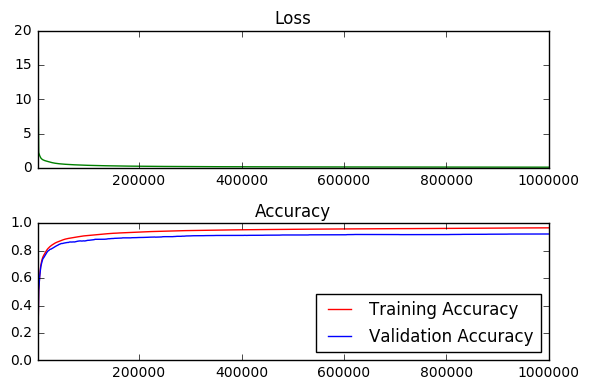

Validation accuracy at 0.9235084056854248
Test accuracy at 0.8139351010322571


In [26]:
import math
from tqdm import tqdm

### Train your model here.
### Feel free to use as many code cells as needed.

# ToDo: Find the best parameters for each configuration
epochs = 500
batch_size = 20
learning_rate = .24

### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0
test_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 2000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
                test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
                print("Validation accuracy: ", validation_accuracy)
                print("Training accuracy: ", training_accuracy)
                print("Test accuracy: ", test_accuracy)
                
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
GradientDescent optimizer
epochs = 500
batch_size = 20
learning_rate = .24


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
The current approach was based on Tensorflow single layer neural network with linear model. Softmax was leveraged for prediction calculations. Gradientdescent optimizer was used for training the model in batches.

Issues encountered: Cross entropy calculation had to be changed. When the images were read from pickle it was in BGR format, had to adjust the implementation

As the epoch size was increased the accuracy increased and loss was minimized


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

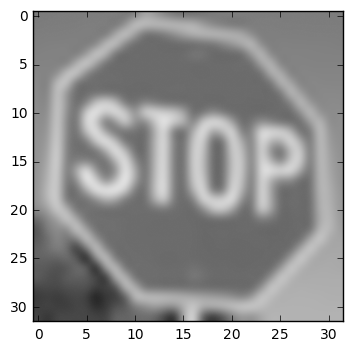

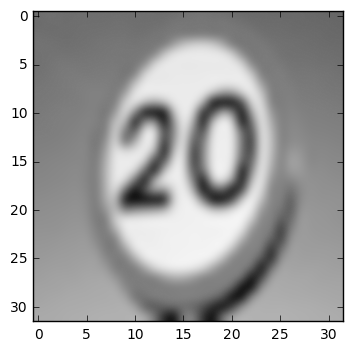

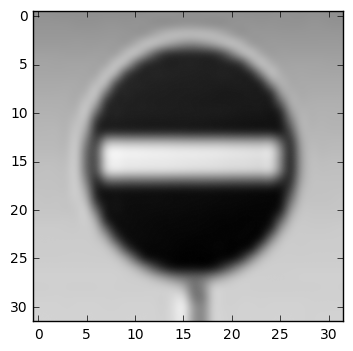

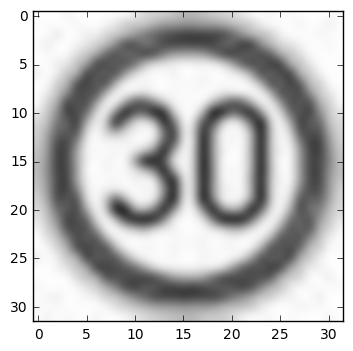

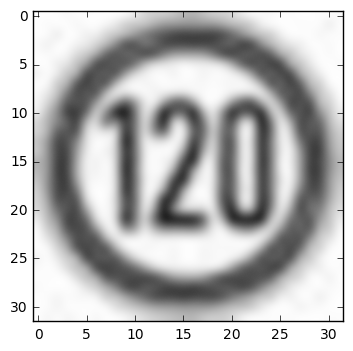

image shape (1024,)
test_model_features.shape (5, 1024)
test_model_features value [[ 0.46392157  0.46392157  0.46705882 ...,  0.63333333  0.63333333
   0.63333333]
 [ 0.42941176  0.44196078  0.43568627 ...,  0.62392157  0.62392157
   0.61764706]
 [ 0.69921569  0.69921569  0.69607843 ...,  0.80901961  0.80901961
   0.80901961]
 [ 0.9         0.9         0.9        ...,  0.9         0.8654902   0.9       ]
 [ 0.9         0.9         0.89686275 ...,  0.9         0.88745098
   0.89058824]]
test_model_labels.shape (5, 43)
test_model_labels value [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.

In [40]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

### Load the images and plot them here.
### Feel free to use as many code cells as needed.
num_test_model_images = 5
num_test_model_labels = 5
img1 = cv2.imread("/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/test/stop.png",0)
img2 = cv2.imread("/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/test/speed-20.png",0)
img3 = cv2.imread("/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/test/no-entry.png",0)
img4 = cv2.imread("/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/test/speed-30.jpg",0)
img5 = cv2.imread("/Users/sharanya.doddapaneni/nanodegree/selfdriving/Archive/test/speed-120.jpg",0)

#cv2.imshow("image", img);

plt.imshow(img1, cmap = 'gray', interpolation = 'bicubic')
plt.show()
img1 = img1.flatten()

plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
plt.show()
img2 = img2.flatten()

plt.imshow(img3, cmap = 'gray', interpolation = 'bicubic')
plt.show()
img3 = img3.flatten()

plt.imshow(img4, cmap = 'gray', interpolation = 'bicubic')
plt.show()
img4 = img4.flatten()

plt.imshow(img5, cmap = 'gray', interpolation = 'bicubic')
plt.show()
img5 = img5.flatten()



print("image shape", img.shape)
test_model_features = np.zeros((num_test_model_images,1024))
test_model_features[0] = img1
test_model_features[1] = img2
test_model_features[2] = img3
test_model_features[3] = img4
test_model_features[4] = img5

test_model_features = normalize_greyscale(test_model_features)

test_model_labels = np.zeros((num_test_model_labels,43))
test_model_labels[0,14] = 1
test_model_labels[1,0]= 1
test_model_labels[2,17]= 1
test_model_labels[3,1]= 1
test_model_labels[4,8]= 1

print ("test_model_features.shape", test_model_features.shape)
print("test_model_features value", test_model_features)
print("test_model_labels.shape", test_model_labels.shape)
print("test_model_labels value", test_model_labels)

test_model_feed_dict = {features: test_model_features, labels: test_model_labels}

#is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))

#Calculate prediction
with tf.Session() as session:
    session.run(init)
    #log = session.run(logits, feed_dict=test_model_feed_dict)
    #log = tf.nn.relu(log)
    #print ("logits", log.eval())
    #tf.Print(log, [log], message="This is logits: ")
    pred = session.run(prediction,feed_dict=test_model_feed_dict)
    print("pred", pred)
    pred_val = session.run([tf.argmax(pred, 1)], feed_dict = test_model_feed_dict)
    print("pred argmax = ", pred_val)
    is_correct_pred = session.run(is_correct_prediction, feed_dict=test_model_feed_dict)
    print("prediction1 = ",is_correct_pred)
    val = session.run([tf.argmax(logits, 1)], feed_dict = test_model_feed_dict) 
    print("logits argmax: ", val)
    test_model_accuracy = session.run(accuracy, feed_dict=test_model_feed_dict)
    print("test_model_accuracy = ",test_model_accuracy)
    values = session.run([tf.nn.top_k(pred, k=5, sorted=True, name=None)], feed_dict = test_model_feed_dict)
    print("values: ", values)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
We had to crop and center the images to make them more readable by the implementation
The images were downloaded from web, the resolution might not be a good quality compared to the training set. When I tried the training set image, one of them returned a true match
The images are plotted for reference

In [28]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
'''Prediction code included above'''

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Testing on the validation dataset gave me about 92% accuracy and test dataset gave me 81%, whereas I am not getting any correct prediction with the downloaded images.

In [29]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
'''Please see the above cell'''

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
The top k only worked for one image out of 5, speed-20 sign.
The others stop-sign,no-entry,speed-30,speed-120 the model was uncertain

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
The images are currently being loaded from the project folder and are loaded/read using cv2.imread
The classification leverages linear model and parts of the implementation from test and training data set implementation was re-used
The prediction model for the training and test data sets didn't work for the new images. Argmax was leveraged to see if there was a match

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.